### Step 0 - Generate data.csv from get_data.py

```bash
$ python get_data.py
```

In [58]:
# Import the libraries
import pandas as pd
import os
import yaml
import math
from sklearn.model_selection import train_test_split

# Plotting
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold

# Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

# Word Embedding
import gensim
import gensim.downloader as gensim_api

# Neural network
from tensorflow.keras import models, layers, preprocessing as kprocessing

[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/juan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [59]:
# Folder to load config file
CONFIG_PATH = "./"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")

### Step 1 - Get the data and preprocess it

In [60]:
# Import data.csv
data = pd.read_csv('data.csv')

# Display only certains columns to have better display
# (missing columns: Nb_Parents, Nb_Children, Has_Nb_Parents_And_Children, Has_Definition)
data.loc[:,['Label', 'Source', 'Definition', 'TUI', 'GUI']].head()

,Label,Source,Definition,TUI,GUI
0,Aircraft,AOD,A weight-carrying structure for navigation of the air that is supported eith...,T073,OBJC
1,Alabama,AOD,A state in the southeastern region of the United States. The capital is Mont...,T083,GEOG
2,alanine,AOD,A non-essential amino acid that occurs in high levels in its free state in p...,T116,CHEM
3,alanine,AOD,A non-essential amino acid that occurs in high levels in its free state in p...,T123,CHEM
4,Alaska,AOD,State of the UNITED STATES OF AMERICA bounded on the east by Canada and on t...,T083,GEOG


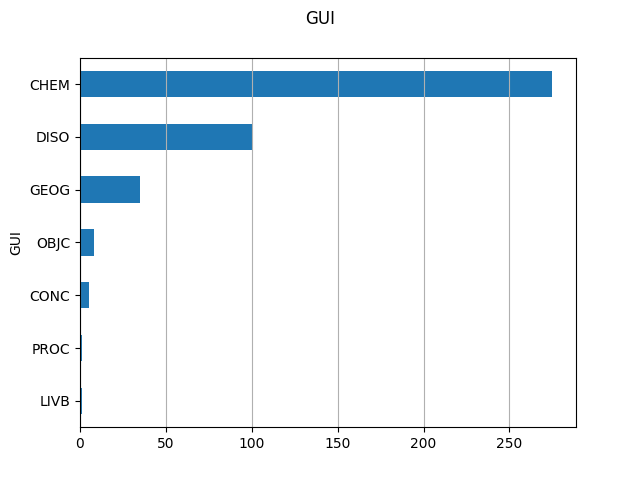

In [61]:
# Plotting the univariate distribution of the data

fig, ax = plt.subplots()
column = config["y_classificaton_column"]
fig.suptitle(column, fontsize=12)
data[column].reset_index().groupby(column).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The graph shows that there are differences of distributions between the GUIs

Time to preprocess the corpus:

In [62]:
# Picture of the difference between stemming and lemmitization: https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png

# TODO Upgrade preprocessing -> special for biomedical data

def utils_preprocessing_corpus(text, stopwords=None, stemming=False, lemmitization=False):
    """This function prepare the corpus for the model.
    It can remove stopwords, lemmatize or stemming.

    Args:
        text (str): corpus to be processed
        stopwords (List[str], optional): stopwords to remove. Defaults to None.
        stemming (bool, optional): process stemming. Defaults to False.
        lemmitization (bool, optional): process lemmitization. Defaults to False.
    """
    # Check if the text is NaN
    if text != text:
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove links
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Split every word
    text = text.split()
    # Remove stopwords
    if stopwords:
        text = [word for word in text if word not in stopwords]
    # Lemmatisation (convert the word into root word)
    if lemmitization == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]
    # Stemming (remove -ing, -ly, ...)
    if stemming == True:
        ps = nltk.stem.porter.PorterStemmer()
        text = [ps.stem(word) for word in text]
    # Join the list of words
    text = " ".join(text)
    return text

stopwords = nltk.corpus.stopwords.words("english")
data.loc[:,"Clean_Definition"] = data.loc[:,"Definition"].apply(utils_preprocessing_corpus, args=(stopwords, config["stemming"], config["lemmitization"]))
# Concatenate Label and Clean_Definition in corpus
data.loc[:,"Clean_Definition"] = data.loc[:,"Label"] + " " + data.loc[:,"Clean_Definition"]

# Show 10 random rows
pd.set_option('display.max_colwidth', 80)
data.loc[:,['Definition', 'Clean_Definition']].sample(10)

,Definition,Clean_Definition
340,A benzimidazole broad-spectrum anthelmintic structurally related to MEBENDAZ...,albendazole benzimidazole broadspectrum anthelmintic structurally related me...
178,"A strain of Murine leukemia virus (LEUKEMIA VIRUS, MURINE) isolated from spo...",AKR murine leukemia virus strain murine leukemia virus leukemia virus murine...
311,"The presence of albumin in the urine, an indicator of KIDNEY DISEASES.",Albuminuria presence albumin urine indicator kidney disease
11,"An alkaloid found in the root of RAUWOLFIA SERPENTINA, among other plant sou...",ajmaline alkaloid found root rauwolfia serpentina among plant source class 1...
98,"The presence of albumin in the urine, an indicator of KIDNEY DISEASES.",Albuminuria presence albumin urine indicator kidney disease
14,A benzimidazole broad-spectrum anthelmintic structurally related to MEBENDAZ...,albendazole benzimidazole broadspectrum anthelmintic structurally related me...
244,A short-acting beta-2 adrenergic agonist that is primarily used as a broncho...,albuterol shortacting beta2 adrenergic agonist primarily used bronchodilator...
93,Increased concentration of albumin in the urine. [Eurenomics:fschaefer],Albuminuria increased concentration albumin urine eurenomicsfschaefer
115,A non-essential amino acid that occurs in high levels in its free state in p...,alanine nonessential amino acid occurs high level free state plasma produced...
7,"Water-soluble proteins found in egg whites, blood, lymph, and other tissues ...",Albumins watersoluble protein found egg white blood lymph tissue fluid coagu...


In [63]:
# Split dataset 70/30
df_train, df_test = train_test_split(data, test_size=0.3)

# Get values
column = config["y_classificaton_column"]
# * TODO column -> config var
y_train = df_train[column].values
y_test = df_test[column].values

Let's tokenize the corpus and train a word2vec model.

In [64]:
corpus = df_train["Clean_Definition"].values

# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   if len(lst_grams) == 0:
      lst_grams = [""]
   lst_corpus.append(lst_grams)

# Detect Bigrams (eg. ['I am', 'a student', '.'])
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# Detect Trigrams (eg. ['I am a', 'student.'])
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

## Fit Word2Vec
nlp = gensim.models.word2vec.Word2Vec(lst_corpus,
   vector_size=config["vector_size"], window=config["window"], min_count=1, sg=1, epochs=config["epochs"])
# * TODO vector_size, window, epochs -> config var
print("The model has been trained on {} words.\n".format(nlp.corpus_total_words))
print("Shape of the word2vec model: ", nlp.wv.vectors.shape)
print("It means that there are {} words in the model.".format(nlp.wv.vectors.shape[0]))
print("And each word has {} dimensions' vector.\n".format(nlp.wv.vectors.shape[1]))

word = "amine"
try:
   print("The most similar words to '{}' are:".format(word), nlp.wv.most_similar(word))
except KeyError:
   print("The word '{}' is not in the vocabulary".format(word))

The model has been trained on 4856 words.

Shape of the word2vec model:  (437, 300)
It means that there are 437 words in the model.
And each word has 300 dimensions' vector.

The word 'amine' is not in the vocabulary


### Even if there are 300 dimensions, we can try to reduce it to 3 thanks to PCA. This will allow us to visualize the words in 3D.

In [65]:
word = "amine"

try:
    # Word Embedding
    tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
    X = nlp.wv[tot_words]

    # PCA to reduce dimensionality from 300 to 3
    pca = manifold.TSNE(perplexity=40, n_components=3, init="pca")
    X = pca.fit_transform(X)

    # Create dtf
    df = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    df["input"] = 0
    df.at["amine","input"]=1

    # Plot 3d
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df[df["input"]==0]["x"], 
               df[df["input"]==0]["y"], 
               df[df["input"]==0]["z"], c="black")
    ax.scatter(df[df["input"]==1]["x"], 
               df[df["input"]==1]["y"], 
               df[df["input"]==1]["z"], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
           yticklabels=[], zticklabels=[])
    for label, row in df[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)
    plt.show()
except Exception as e:
    print("Error: " + str(e))


Error: "Key 'amine' not present"


### To include the corpus as features in a Neural Network, we need to:

1- Transform the corpus into padded sequences of words

2- Create Embedding matrix with as index the id's word and as value it vector

3- Set Embedding layer in the Neural Network so that weights every word

<AxesSubplot:>

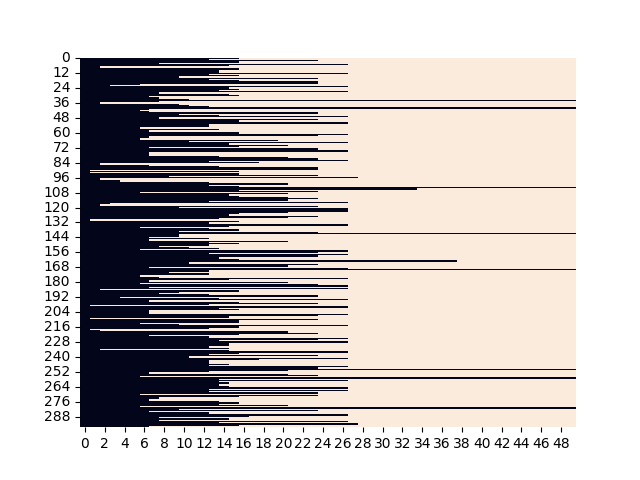

In [66]:
# Tokenize text -> Indexation of each word (eg. {'NaN': 1, 'enzyme': 2, 'amine': 3...})
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN",
                                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

# Create sequence -> Use index of each word from 'tokenizer' to create sentences (eg. ['amine', 'enzyme'] -> [3, 2])
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
# (eg. [3, 2] -> [3, 2, 0, 0, 0, 0, ..., 0])
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")
# * TODO maxlen -> config var

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)

Let's do the same for the test part.
Why did we separe the train and test data set ?

To be sure the bigrams, trigrams and tokenizer are trained only with the training set and keep the test set unknown of any model.

In [ ]:
corpus = df_test["Clean_Definition"]

# TODO create function to do this part -> no duplicated code
# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
# Detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# Text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")
# * TODO maxlen -> config var

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)

<AxesSubplot:>

In [ ]:
# Embedding TODO

**Embedding Matrix Explanation**:
![Embedding Matrix Explanation](https://miro.medium.com/max/700/1*KvBp0xzRThA7qTXACT4A-g.png)